In [10]:
import numpy as np
import gymnasium as gym
from gymnasium.spaces import Dict, Discrete, Box
import torch

import os 
import sys

sys.path.append(os.path.abspath('../..'))

from environment.env import POMDPDeformedGridworld

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(7, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,deform_obs,theta):
        x = torch.cat([pos,deform_obs,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
obs_model = NN()

# Load the model
obs_model.load_state_dict(torch.load('obs_model.pth',map_location=torch.device('cpu') ,weights_only=True))

obs_model.eval()
obs_model(torch.tensor([0.5, 0.5]).unsqueeze(0), torch.tensor([1.0]).unsqueeze(0), torch.tensor([0.5, 0.0, 0.0, 0.5]).unsqueeze(0))

tensor([[1.]], grad_fn=<SigmoidBackward0>)

# DISCRETE BELIEF UPDATE TESTING

In [12]:
class POMDPAgent():
    def __init__(self, env: POMDPDeformedGridworld, obs_model, discretization=10, update='discrete'):
        self.env = env
        self.obs_model = obs_model

        if update == 'discrete': 
            # assuming discrete belief over 2 parameters
            belief_points = np.linspace(env.stretch_range[0], env.stretch_range[1], discretization) 
            # zip belief points in every combination
            import itertools
            self.tmp_belief_points = { bp:0 for bp in itertools.product(belief_points, belief_points) }
            self.belief_points = torch.tensor(list(self.tmp_belief_points.keys()), dtype=torch.float32)

            self.belief_values = torch.ones(self.belief_points.shape[0], dtype=torch.float32) / len(self.tmp_belief_points.keys())

            self.belief_update = self.discrete_belief_update
        else:
            raise NotImplementedError('Only discrete belief update is supported')
        
    def act(self):
        action = input('Enter action: ')
        pomdp_state, reward, terminated,truncated, info = self.env.step(int(action))
        print(pomdp_state)
        self.belief_update(pomdp_state)

    def discrete_belief_update(self, pomdp_state):
        """discrete belief update"""
        obs = pomdp_state['obs']
        pos = pomdp_state['pos']

        batch_pos = pos.repeat(len(self.belief_points), 1)
        batch_obs = obs.repeat(len(self.belief_points), 1)
        
        # need theta because working on two parameters only in this example
        # siamo sicuri che sia l'ordine gisuto ??
        theta = torch.cat([self.belief_points, torch.zeros(len(self.belief_points), 2)], dim=1)
        # permute theta to match the order of pos
        theta = theta[:, [0,3,2,1]]
        

        likelihood = self.obs_model(batch_pos,batch_obs, theta)
        self.belief_values =  torch.einsum("ij,j->i",likelihood, self.belief_values)
        self.belief_values = self.belief_values / self.belief_values.sum()
        
    def render_act(self):
        """For testing belief convergence"""
        pomdp_state = self.env.get_state()
        self.belief_update(pomdp_state)
        self.env.render()       

In [14]:
pomdp_env = POMDPDeformedGridworld()
agent = POMDPAgent(pomdp_env, obs_model, discretization=20)


In [15]:
pomdp_env = POMDPDeformedGridworld()

pomdp_env.set_deformation([0.5, 0.8],[0,0])

agent = POMDPAgent(pomdp_env, obs_model,20)
b = agent.belief_points[torch.argmax(agent.belief_values)]
while True:
    try:
        agent.render_act()
        assert torch.allclose(agent.belief_values.sum(), torch.tensor([1.0])), f"Belief values do not sum to 1: {agent.belief_values.sum()}"
        # print(agent.belief_values)
        # print argmax
        if torch.any(b != agent.belief_points[torch.argmax(agent.belief_values)]):
            b = agent.belief_points[torch.argmax(agent.belief_values)]
            print(b)
    except:
        print('raised exception')
        break

tensor([0.4000, 0.4947])
tensor([0.4000, 0.4632])
tensor([0.4000, 0.4947])
tensor([0.4000, 0.4632])
tensor([0.4000, 0.4947])
tensor([0.4000, 1.0000])
tensor([1.0000, 0.6526])
tensor([1., 1.])
tensor([0.4000, 1.0000])
tensor([0.4000, 0.4947])
tensor([0.4000, 0.4000])
tensor([0.4000, 0.4316])
tensor([0.4632, 1.0000])
tensor([0.5895, 0.9684])
tensor([0.6211, 0.9684])
tensor([0.4000, 0.5579])
tensor([0.4316, 0.4632])
tensor([0.4000, 0.4000])
tensor([1., 1.])
tensor([1.0000, 0.4000])
tensor([0.7789, 0.4000])
tensor([1.0000, 0.4000])
tensor([0.4000, 1.0000])
tensor([0.7789, 0.4000])
tensor([1.0000, 0.4000])
tensor([0.4000, 1.0000])
tensor([0.7789, 0.4000])
tensor([1.0000, 0.4000])
raised exception


In [8]:
assert torch.allclose(agent.belief_values.sum(), torch.tensor([1.0])), f"Belief values do not sum to 1: {agent.belief_values.sum()}"


AssertionError: Belief values do not sum to 1: nan

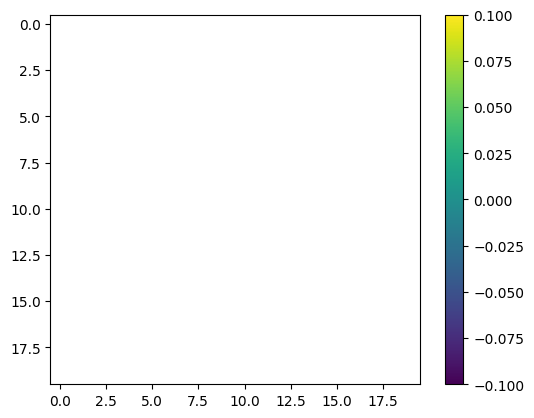

In [9]:
# plot belief values
import matplotlib.pyplot as plt
plt.imshow(agent.belief_values.detach().numpy().reshape(20, 20))
plt.colorbar()
plt.show()


# VARIATIONAL UPDATE

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

# Variational distribution q(theta; lambda)
class VariationalDistribution(nn.Module):
    def __init__(self, dim):
        super(VariationalDistribution, self).__init__()
        self.mu = nn.Parameter(torch.zeros(dim))  # Mean of q(theta)
        self.log_sigma = nn.Parameter(torch.zeros(dim))  # Log std dev of q(theta)
    
    def sample(self, num_samples=1):
        epsilon = torch.randn(num_samples, self.mu.size(0), device=self.mu.device)  # Sample from N(0, I)
        sigma = torch.exp(self.log_sigma)
        return self.mu + sigma * epsilon  # Reparameterization trick
    
    def kl_divergence(self, prior_mu, prior_sigma):
        # KL divergence between two Gaussians: KL[q || p]
        prior = Normal(prior_mu, prior_sigma)
        q = Normal(self.mu, torch.exp(self.log_sigma))
        return torch.distributions.kl_divergence(q, prior).sum()

def compute_elbo(phi_net, variational_dist, prior_mu, prior_sigma, target_o, num_samples=100):
    """
    Compute the Evidence Lower Bound (ELBO) for variational inference.
    """
    # Sample theta ~ q(theta; lambda)
    theta_samples = variational_dist.sample(num_samples)
    
    # Forward pass through phi(theta)
    phi_values = phi_net(theta_samples)  # phi(theta)
    
    # Reconstruction loss (negative log-likelihood approximation)
    reconstruction_loss = ((phi_values - target_o) ** 2).mean()
    
    # KL divergence between q(theta) and prior p(theta)
    kl_div = variational_dist.kl_divergence(prior_mu, prior_sigma)
    
    # ELBO: maximize likelihood - KL divergence
    elbo = -reconstruction_loss - kl_div
    return elbo



In [14]:
class POMDPAgent():
    def __init__(self, env: POMDPDeformedGridworld, obs_model):
        self.env = env
        self.obs_model = obs_model
        
        # assuming gaussian belief over 4 parameter deformation matrix
        self.belief = {
            'mean': torch.tensor([0.5, 0.0, 0.0, 0.5], dtype=torch.float32, requires_grad=True),
            'cov': torch.eye(4) * 0.1
        }

        self.prior_mu = self.belief['mean']
        self.prior_sigma = self.belief['cov']

        self.variational_distribution = VariationalDistribution(4)
    
    def act(self):
        action = input('Enter action: ')
        pomdp_state, reward, terminated,truncated, info = self.env.step(int(action))
        print(pomdp_state)
        self.belief_update(pomdp_state)

    def belief_update(self, pomdp_state):
        # Optimizer
        optimizer = optim.Adam(list(self.obs_model.parameters()) + list(self.variational_distribution.parameters()), lr=1e-2)

        # Training loop
        num_epochs = 1000
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            
            # Compute ELBO
            elbo = compute_elbo(self.obs_model, self.variational_distribution, self.prior_mu, self.prior_sigma, pomdp_state['obs'])
            
            # Maximize ELBO (minimize negative ELBO)
            loss = -elbo
            loss.backward()
            optimizer.step()
                
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{num_epochs}, ELBO: {elbo.item():.4f}")


        self.prior_mu = self.variational_distribution.mu.detach()
        self.prior_sigma = torch.exp(self.variational_distribution.log_sigma.detach())

    def render_act(self):
        """For testing belief convergence"""
        pomdp_state = self.env.get_state()
        self.belief_update(pomdp_state)
        self.env.render()
        

In [15]:
agent = POMDPAgent(pomdp_env, obs_model)

agent.belief_update(pomdp_env.get_state())

TypeError: NN.forward() missing 2 required positional arguments: 'deform_obs' and 'theta'

# obs model loading

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        self.f1 = nn.Linear(7, 128)
        self.f2 = nn.Linear(128, 128)
        self.f3 = nn.Linear(128, 128)
        self.f4 = nn.Linear(128, 1)
        
    def forward(self, pos,deform_obs,theta):
        x = torch.cat([pos,deform_obs,theta], dim=1)
        x = F.relu(self.f1(x))
        x = F.relu(self.f2(x))
        x = F.relu(self.f3(x))
        x = F.sigmoid(self.f4(x))
        return x

# Instantiate the model
obs_model = NN()

# Load the model
obs_model.load_state_dict(torch.load('obs_model.pth',map_location=torch.device('cpu') ))

/tmp/ipykernel_64619/1319120195.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obs_model.load_state_dict(torch.load('obs_model.pth',map_location=torch.device('cpu') ))

<All keys matched successfully>

In [7]:
obs_model.eval()
obs_model(torch.tensor([0.5, 0.5]).unsqueeze(0), torch.tensor([1.0]).unsqueeze(0), torch.tensor([0.5, 0.0, 0.0, 0.5]).unsqueeze(0))

tensor([[0.9985]], grad_fn=<SigmoidBackward0>)

In [8]:
agent = POMDPAgent(pomdp_env, obs_model)

In [9]:
pomdp_env = POMDPDeformedGridworld()
pomdp_env.reset()

agent = POMDPAgent(pomdp_env, obs_model)

while True:
    try:
        agent.render_act()
    except:
        break

In [11]:
agent.belief


{'mean': tensor([0.5000, 0.0000, 0.0000, 0.5000], requires_grad=True),
 'cov': tensor([[0.1000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.1000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1000]])}

For Vector Outputs (Multi-class or Multi-dimensional)

If h(M)h(M) outputs a vector instead of a scalar, compute the Jacobian as follows:

In [ ]:
# Example for vector-valued outputs (e.g., multi-class observation model)
mu = torch.tensor([0.5, 0.5, 0.1, 0.1], requires_grad=True)
obs_pred = model(mu)  # Assume model now outputs a vector, e.g., shape (3,)
jacobian = torch.zeros(obs_pred.shape[0], mu.shape[0])  # Preallocate Jacobian (3x4)

# Compute Jacobian row by row
for i in range(obs_pred.shape[0]):
    model.zero_grad()  # Clear gradients
    obs_pred[i].backward(retain_graph=True)  # Backprop for the i-th output
    jacobian[i] = mu.grad  # Store the gradient
    mu.grad.zero_()  # Reset gradients for next iteration

print("Jacobian (multi-dimensional output):")
print(jacobian)


In [115]:
import torch
import torch.nn as nn

# Define the observation model (neural network)
class ObservationModel(nn.Module):
    def __init__(self):
        super(ObservationModel, self).__init__()
        self.fc1 = nn.Linear(4, 16)  # Input: 4D vector, hidden: 16 neurons
        self.fc2 = nn.Linear(16, 1)  # Output: scalar (0 or 1)
        self.activation = nn.Sigmoid()  # Sigmoid output (probability-like)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.activation(self.fc2(x))
        return x

# Kalman filter update step
def kalman_update(mu, P, z, H, R):
    """
    Perform the Kalman update step for the belief.
    - mu: Current belief mean
    - P: Current belief covariance
    - z: Observation (0 or 1)
    - H: Jacobian of the observation model
    - R: Observation noise covariance
    """
    # Compute the Kalman gain
    K = torch.matmul(P, H.T) * torch.inverse(H @ P @ H.T + R).squeeze(0)
    
    # Update the belief
    mu_new = mu + K * (z - H @ mu)
    P_new = P - K @ H * P
    
    return mu_new, P_new

# Initialize the neural network
model = ObservationModel()

# Current belief (Gaussian) parameters: mean (mu) and covariance (P)
mu = torch.tensor([0.5, 0.56, 0.1, 0.1], dtype=torch.float32, requires_grad=True)  # Example mean of the belief
P = torch.eye(4)  # Example covariance (identity for simplicity)

# The observation model is a neural network, so let's predict the observation
obs_pred = model(mu)  # Predicted observation for the current belief

# For simplicity, assume we have an observation (0 or 1)
z = torch.tensor([1.0])  # Example observed value

# Compute the Jacobian (derivative of the observation model w.r.t. mu)
obs_pred.backward()  # Compute the gradients of the prediction wrt mu
H = mu.grad.clone()   # The Jacobian is just the gradient of the output with respect to the input (mu)

# Reset gradients for the next iteration
mu.grad.zero_()

# Assume a simple observation noise model (R)
R = torch.tensor([[0.01]])  # Small observation noise

# Perform Kalman update
mu_new, P_new = kalman_update(mu, P, z, H, R)

print("Updated belief mean:", mu_new)
print("Updated belief covariance:", P_new)


Updated belief mean: tensor([-1.6752, -0.7079,  0.0612, -2.2841], grad_fn=<AddBackward0>)
Updated belief covariance: tensor([[0.8676, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8676, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8676, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.8676]])


In [93]:
# sample from a Gaussian distribution with mean mu and covariance P using pytorch
def sample_gaussian(mu, P):
    """
    Sample from a Gaussian distribution with mean mu and covariance P.
    
    Parameters:
        mu (torch.Tensor): Mean of the Gaussian (vector).
        P (torch.Tensor): Covariance matrix of the Gaussian.
    
    Returns:
        sample (torch.Tensor): Sampled value from the Gaussian.
    """
    # Generate a sample from a standard normal distribution
    sample = torch.randn_like(mu)
    
    # Perform Cholesky decomposition of the covariance matrix
    L = torch.linalg.cholesky(P)
    
    # Transform the sample to match the desired covariance
    sample = mu + L @ sample
    
    return sample

# Example usage
sample_gaussian(mu_new, P_new)

tensor([1.8000, 3.3302, 0.7704, 1.9053], grad_fn=<AddBackward0>)

In [86]:
# Compute the Kalman gain
print('shape P', P.shape)
print('shape H', H.shape)
print('shape R', R.shape)
K = torch.matmul(P, H.T) * torch.inverse(H @ P @ H.T + R).squeeze(0)

# Update the belief
mu_new = mu + K * (z - H @ mu)
P_new = P - K @ H * P



shape P torch.Size([4, 4])
shape H torch.Size([4])
shape R torch.Size([1, 1])


In [85]:
K@ H * P

tensor([[0.1259, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1259, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1259, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1259]])

In [81]:
P_new = P - K @ H @ P

RuntimeError: both arguments to matmul need to be at least 1D, but they are 0D and 2D

tensor(-0.0114, grad_fn=<DotBackward0>)

In [70]:
torch.inverse(H @ P @ H.T + R).squeeze(0)

tensor([87.7421])

In [59]:
obs_pred = model(mu)  # Predicted observation for the current belief

# For simplicity, assume we have an observation (0 or 1)
z = torch.tensor([1.0])  # Example observed value

# Compute the Jacobian (derivative of the observation model w.r.t. mu)
obs_pred.backward()  # Compute the gradients of the prediction wrt mu
H = mu.grad.clone()  # The Jacobian is
H

tensor([-0.0451, -0.1558,  0.2192,  0.0721])

In [66]:
t = torch.tensor([[1.0, 2.0, 3.0, 4.0],[4,3,2,1]], dtype=torch.float32, requires_grad=True)
t
a = 3

t*a

tensor([[ 3.,  6.,  9., 12.],
        [12.,  9.,  6.,  3.]], grad_fn=<MulBackward0>)